# MODELADO ARIMA

## 1. Cargar serie de tiempo 

In [74]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from math import floor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import warnings
import itertools

serie = pd.read_csv("../data/processed/serie_preparada.csv", index_col=0, parse_dates=True)
metrica = "total_pkts"

# Estilo para los graficos
plt.style.use("seaborn-v0_8")

# Indice con versión númerica para ARIMA
serie[metrica] = pd.to_numeric(serie[metrica], errors="coerce")


# Se agrega la frecuencia para filtrar wraning, porque ARIMA ve un DateTimeIndex pero no sabe que frecuencia tiene
freq = pd.infer_freq(serie.index)

if freq is not None:
    serie = serie.asfreq(freq)
    serie.index.freq = freq
print(serie.info())
serie.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2017-07-07 03:30:00 to 2017-07-07 05:02:00
Freq: min
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   total_pkts  93 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB
None


,total_pkts
timestamp,
2017-07-07 03:30:00,43583
2017-07-07 03:31:00,27517
2017-07-07 03:32:00,3899
2017-07-07 03:33:00,16056
2017-07-07 03:34:00,10606


## 2. Seleccionar ventana benigna y serie completa

Ventana benigna
2017-07-07 03:30:00 -> 2017-07-07 03:55:00 n =  26


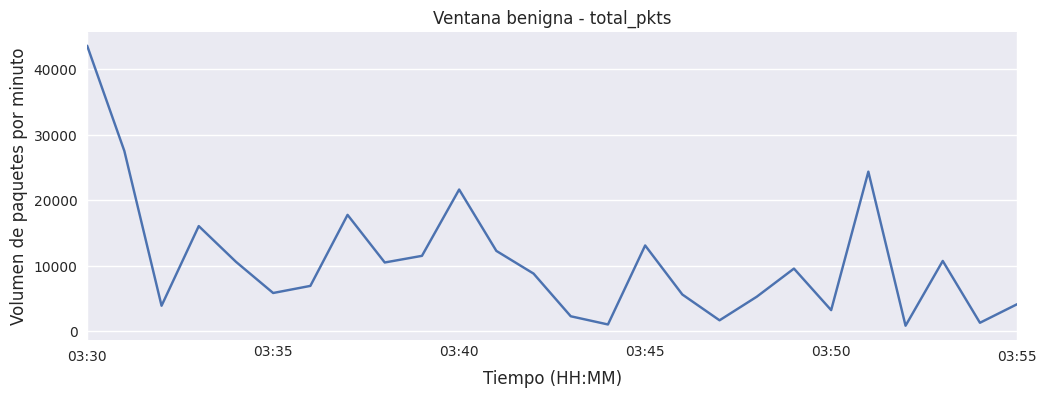

In [75]:
# Marca de cuando inicia el ataque DDoS en el dataset
inicio_ataque = pd.Timestamp("2017-07-07 03:56:00")

# Serie completa (para prediccción final)
serie_completa = serie[metrica].copy()


# Serie de entrenamiento, solo tramo benignos
serie_entrenamiento = serie_completa[serie_completa.index < inicio_ataque].copy()

print("Ventana benigna")
print(serie_entrenamiento.index.min(), "->", serie_entrenamiento.index.max(), "n = ", len(serie_entrenamiento))

plt.figure(figsize=(12,4))
serie_entrenamiento.plot()
plt.title("Ventana benigna - total_pkts")
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)
plt.show()

## 3. Revisisón de ACF y PACF en la ventana benigna

n_entrenamiento:  26
max_lags_acf:  20
max_lags_pacf:  12
Gráfico exportado exitosamente a:  ../results/14_ACF_PACF_Ventana_beningna.png


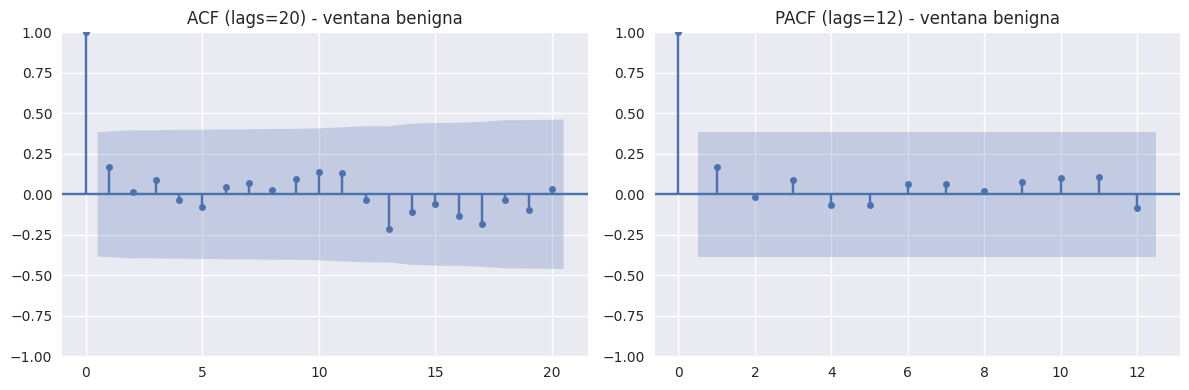

In [76]:
n_entrenamiento = len(serie_entrenamiento)

# lags máximos seguros para ACF (puede ser hasta n-1, pero limitamos a 20)
max_lags_acf = max(1, min(20, n_entrenamiento - 1))

# lags máximos seguros para PACF (statsmodels exige < n//2)
max_lags_pacf = max(1, min(20, (n_entrenamiento//2) - 1))


print("n_entrenamiento: ",n_entrenamiento)
print("max_lags_acf: ", max_lags_acf)
print("max_lags_pacf: ", max_lags_pacf)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(serie_entrenamiento, lags=max_lags_acf, ax=axes[0])
axes[0].set_title(f"ACF (lags={max_lags_acf}) - ventana benigna")

plot_pacf(serie_entrenamiento, lags=max_lags_pacf, ax=axes[1])
axes[1].set_title(f"PACF (lags={max_lags_pacf}) - ventana benigna")

plt.tight_layout()

# Exportar el gráfico
ruta = "../results/14_ACF_PACF_Ventana_beningna.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

## 4. Selección de (p,q) usando IAC

In [77]:
# Filtramos warnings que no afectan la reproducibilidad del resultado
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


y_train = serie_entrenamiento
resultados = []

p_valores = range(0,4)  # p = 0,1,2,3
q_valores = range(0,4)  # q = 0,1,2,3

for p, q in itertools.product(p_valores, q_valores):
    if p == 0 and q == 0:
        continue  #ARIMA(0,0,0) es trivial y no aporta
    try:
        modelo = ARIMA(y_train,
                       order=(p,0,q),
                       enforce_stationarity=True,
                       enforce_invertibility=True)
        resultado = modelo.fit()

        # Si el optimizador no convergió, descartamos este modelo
        converged = resultado.mle_retvals.get("converged", True)
        if not converged:
            continue
            
        resultados.append({"p": p, "q": q, "aic": resultado.aic})
    except Exception as e:
        #La excepción es para los parámteros que no convergen 
        print(f"Falló ARIMA({p},0,{q}) --> {e}")
        continue

df_modelos = pd.DataFrame(resultados).sort_values("aic")
df_modelos

# Mostrar los mejores parámetros para ARIMA
print("="*60)
print("ANÁLISIS DE SELECCIÓN DE MODELOS ARIMA")
print("="*60)

# Obtener el mejor modelo (menor AIC)
mejor_modelo = df_modelos.iloc[0]

print(f"\n🏆 MEJOR MODELO ENCONTRADO: ARIMA({int(mejor_modelo['p'])},0,{int(mejor_modelo['q'])})")
print(f"   • AIC = {mejor_modelo['aic']:.2f}")

# Mostrar top 3 modelos
print(f"\n📊 TOP 3 MODELOS (ordenados por AIC):")
print("-"*40)
for i in range(min(3, len(df_modelos))):
    modelo = df_modelos.iloc[i]
    print(f"{i+1}. ARIMA({int(modelo['p'])},0,{int(modelo['q'])}): AIC = {modelo['aic']:.2f}")

# Mostrar todos los modelos evaluados
print(f"\n📈 TOTAL DE MODELOS EVALUADOS: {len(df_modelos)}")
print(f"  • Valores de p probados: {list(p_valores)}")
print(f"  • Valores de q probados: {list(q_valores)}")

# Verificar si hay más de un modelo bueno
if len(df_modelos) > 1:
    dif_aic = df_modelos.iloc[1]['aic'] - mejor_modelo['aic']
    print(f"\n💡 Diferencia de AIC con el segundo mejor modelo: {dif_aic:.2f}")
    
    # Regla general: diferencia > 2 significa que el modelo es significativamente mejor
    if dif_aic > 2:
        print("   ✓ El mejor modelo es significativamente mejor (diferencia > 2 en AIC)")
    else:
        print("   ⚠️ Los modelos tienen AIC similar, considerar ambos")
        
print("\n" + "="*60)

ANÁLISIS DE SELECCIÓN DE MODELOS ARIMA

🏆 MEJOR MODELO ENCONTRADO: ARIMA(0,0,1)
   • AIC = 555.79

📊 TOP 3 MODELOS (ordenados por AIC):
----------------------------------------
1. ARIMA(0,0,1): AIC = 555.79
2. ARIMA(1,0,1): AIC = 557.52
3. ARIMA(2,0,0): AIC = 557.56

📈 TOTAL DE MODELOS EVALUADOS: 10
  • Valores de p probados: [0, 1, 2, 3]
  • Valores de q probados: [0, 1, 2, 3]

💡 Diferencia de AIC con el segundo mejor modelo: 1.73
   ⚠️ Los modelos tienen AIC similar, considerar ambos



## 5. Ajustar ARIMA(0,0,1) y analizar residuos

In [78]:
residuos_entrenamiento.index

DatetimeIndex(['2017-07-07 03:30:00', '2017-07-07 03:31:00',
               '2017-07-07 03:32:00', '2017-07-07 03:33:00',
               '2017-07-07 03:34:00', '2017-07-07 03:35:00',
               '2017-07-07 03:36:00', '2017-07-07 03:37:00',
               '2017-07-07 03:38:00', '2017-07-07 03:39:00',
               '2017-07-07 03:40:00', '2017-07-07 03:41:00',
               '2017-07-07 03:42:00', '2017-07-07 03:43:00',
               '2017-07-07 03:44:00', '2017-07-07 03:45:00',
               '2017-07-07 03:46:00', '2017-07-07 03:47:00',
               '2017-07-07 03:48:00', '2017-07-07 03:49:00',
               '2017-07-07 03:50:00', '2017-07-07 03:51:00',
               '2017-07-07 03:52:00', '2017-07-07 03:53:00',
               '2017-07-07 03:54:00', '2017-07-07 03:55:00'],
              dtype='datetime64[ns]', name='timestamp', freq='min')

                               SARIMAX Results                                
Dep. Variable:             total_pkts   No. Observations:                   26
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -274.893
Date:                Mon, 08 Dec 2025   AIC                            555.785
Time:                        06:47:02   BIC                            559.560
Sample:                    07-07-2017   HQIC                           556.872
                         - 07-07-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.1e+04   2374.939      4.632      0.000    6345.573    1.57e+04
ma.L1          0.2488      0.222      1.123      0.262      -0.186       0.683
sigma2       8.91e+07      0.222   4.02e+08      0.0

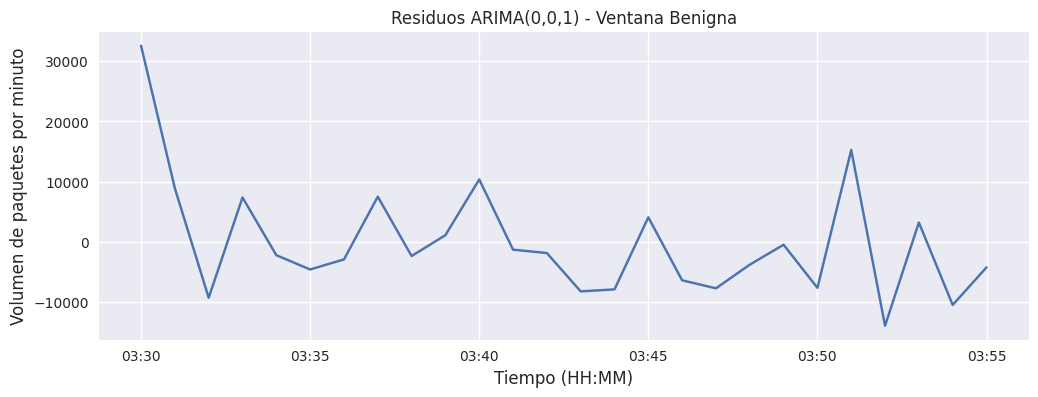

Gráfico exportado exitosamente a:  ../results/16_ACF_PACF_Ventana_Benigna_Residuos.png


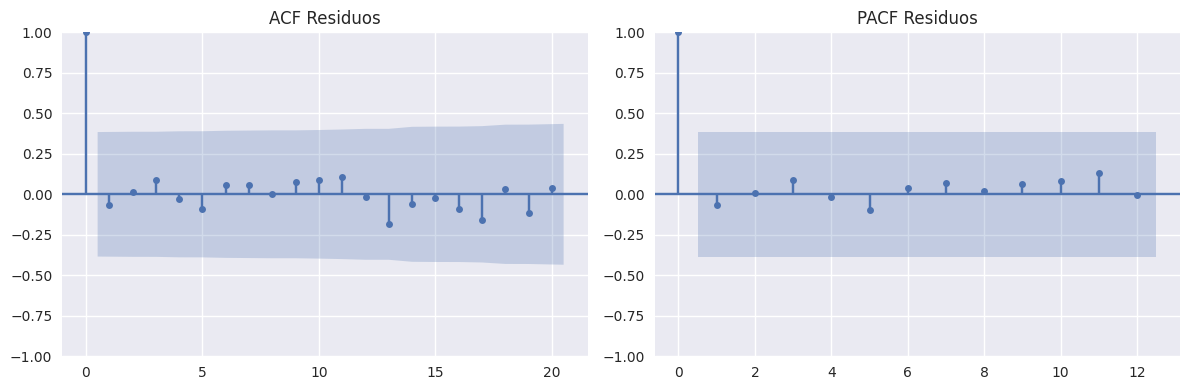

In [79]:
parametro_p,parametro_q = 0, 1

model_arima = ARIMA(serie_entrenamiento, order=(parametro_p, 0, parametro_q))
resultado_final = model_arima.fit()

print(resultado_final.summary())

residuos_entrenamiento = resultado_final.resid

plt.figure(figsize=(12,4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.plot(residuos_entrenamiento)
plt.title("Residuos ARIMA(0,0,1) - Ventana Benigna")
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)

# Exportar el gráfico
ruta = "../results/15_Residuos_ARIMA_Ventana_Benigna.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

# ACF y PACF de residuos (esperamos ruido blanco)
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_acf(residuos_entrenamiento, lags=max_lags_acf, ax=axes[0])
axes[0].set_title("ACF Residuos")


plot_pacf(residuos_entrenamiento, lags=max_lags_pacf, ax=axes[1])
axes[1].set_title("PACF Residuos")



plt.tight_layout()
# Exportar el gráfico
ruta = "../results/16_ACF_PACF_Ventana_Benigna_Residuos.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

## 6. Generar predicciones sobre la serie completa y calcular residuos

In [84]:
# Gnerar predicciones dentro de la ventana benigna (IN-SAMPLE)
prediccion_entrenamiento = resultado_final.fittedvalues
prediccion_entrenamiento.head()

timestamp
2017-07-07 03:30:00    11000.368393
2017-07-07 03:31:00    18633.043701
2017-07-07 03:32:00    13202.322093
2017-07-07 03:33:00     8686.671868
2017-07-07 03:34:00    12833.471084
Freq: min, dtype: float64

In [85]:
# Generar predicciones desde el ataque en adelante (OUT-OF-SAMPLE)
n_completa = len(serie_completa)
n_entrenamiento = len(serie_entrenamiento)
n_out = n_completa - n_entrenamiento

prediccion_out = resultado_final.forecast(steps=n_out)
prediccion_out.head()

2017-07-07 03:56:00     9942.939958
2017-07-07 03:57:00    11000.368393
2017-07-07 03:58:00    11000.368393
2017-07-07 03:59:00    11000.368393
2017-07-07 04:00:00    11000.368393
Freq: min, Name: predicted_mean, dtype: float64

In [86]:
# Construir prediccíón completa
pred_full_values = np.concatenate([prediccion_entrenamiento.values, prediccion_out.values])

# Valores predichos bajo normalidad
pred_full = pd.Series(pred_full_values, index=serie_completa.index, name="pred_arima")

Gráfico exportado exitosamente a:  ../results/17_Paquetes_Minuto_ARIMA_Residuo.png


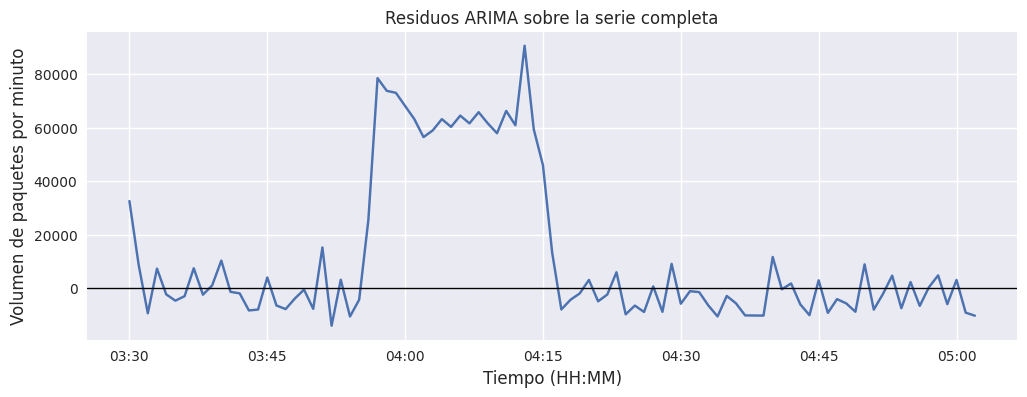

In [87]:
residuos_full = serie_completa - pred_full
plt.figure(figsize=(12,4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.plot(residuos_full)
plt.title("Residuos ARIMA sobre la serie completa")
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)
plt.axhline(0, color="black", linewidth=1)

# Exportar el gráfico
ruta = "../results/17_Paquetes_Minuto_ARIMA_Residuo.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

In [88]:
# Exportar residuo de arima a CSV
ruta = "../data/processed/residuos_arima.csv"
df_residuos = pd.DataFrame({"residuos_arima": residuos_full})
df_residuos.to_csv(ruta)
print("Archivo Generado:", ruta)

Archivo Generado: ../data/processed/residuos_arima.csv
